In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re
import pickle

In [2]:
class LBP():
    def __init__(self, histogram, path):
        self.histogram = histogram
        self.path = path

In [3]:
class Output():
    def __init__(self, path, distance):
        self.distance = distance
        self.path = path

In [4]:
def histogram_distance(first, second):
    dist = 0
    for i in range (0,256):
        dist += abs(first[i]-second[i])
    return dist

In [5]:
def find_closests(array, histogram, path):#it finds the closest histograms which in array to the given histogram
    first = Output("", 100000)
    second = Output("", 100000)
    third = Output("", 100000)
    for i in array:
        dist = histogram_distance(i.histogram, histogram)
        if dist<first.distance:
            third.distance = second.distance
            third.path = second.path
            second.distance = first.distance
            second.path = first.path
            first.path = i.path
            first.distance = dist
        elif dist< second.distance:
            third.distance = second.distance
            third.path = second.path
            second.path = i.path
            second.distance = dist
        elif dist<third.distance:
            third.path = i.path
            third.distance = dist
    return first, second, third

In [6]:
def normalize(image):#normalize image
    min = np.min(image)
    max = np.max(image)
    row, column = image.shape
    normalized =  np.empty([row, column])
    for i in range (0,row):
        for j in range (0, column):
            normalized[i,j] = ((image[i,j]-min)/(max-min))*255

    return normalized


In [7]:
def normalize_histogram(array):
    sum = np.sum(array)
    size = array.size
    normalized =  np.empty([size, 1])
    for i in range (0,size):
        normalized[i] = round(array[i]/(sum), 5)
    return normalized

In [8]:
def rgbToGray(image):#convert RGB image to Gray scale image
    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]
    row, column, domain = image.shape
    gray_image =  np.empty([row, column])
    for i in range (0,row):
        for j in range (0, column):
            gray_image[i,j] = int(16 + (65.738*red[i,j] + 129.057*green[i,j] + 25.064*blue[i,j])/256)
    return gray_image


In [9]:
def compare(center, other): #this method compares two values for Uniform LBP
    if center > other:
        return 1
    else:
        return 0

In [10]:
def local_binary_pattern(image):#method takes gray scale image as parameter and returns LBP histogram
    row, column = image.shape
    histogram = np.zeros(256, dtype = int)
    cell=np.zeros(8, dtype = int)
    for i in range (1, row-1):
        for j in range (1, column-1):
            value=0
            count = 0
            cell[0] = compare(image[i, j], image[i-1,j-1])
            cell[1] = compare(image[i, j], image[i-1,j])
            cell[2] = compare(image[i, j], image[i-1,j+1])
            cell[3] = compare(image[i, j], image[i,j-1])
            cell[4] = compare(image[i, j], image[i,j+1])
            cell[5] = compare(image[i, j], image[i+1,j-1])
            cell[6] = compare(image[i, j], image[i+1,j])
            cell[7] = compare(image[i, j], image[i+1,j+1])
            for k in range (0, 7):
                if(cell[k] != cell[k+1]):
                    count+=1
            for k in range (0, 8):
                value+=pow(2,7-k)*cell[k]#binary to decimal
            if count <= 2:
                histogram[value] += 1
    histogram = normalize_histogram(histogram)
    return histogram


In [11]:
def test(filename, files_dir):# filename: "train_data.txt", files_dir: "test" or "testRaporaEklenecek"
    dictionary = {'banded': 0, 'bubbly':0,'chequered':0,'cobwebbed':0,'crystalline':0,'dotted':0,'honeycombed':0,'striped':0,'zigzagged':0} # dictionary keeps the number of matches of classes
    success = {0:0, 1:33, 2:66, 3:100}
    sum = 0
    num_of_files = 0
    with open(filename, 'rb') as file:#no need for file.close() with this scope. file will be closed after scope
        loaded_list = pickle.load(file)#loading the array which has Uniform LBP histograms from train_data.txt
    file_paths = os.listdir(f'./{files_dir}/')
    for file_name in file_paths:
        count = 0
        image_path = f'./{files_dir}/{file_name}'
        if re.search(".*\.jpg", image_path):
            image = mpimg.imread(image_path)
            image_type = re.split("_|/", image_path)[2]#it returns the type of image like banded, bubbly etc.
            gray_image = rgbToGray(image)
            norm_gray_image = normalize(gray_image)
            hist = local_binary_pattern(norm_gray_image)
            ready_lbp = LBP(histogram=hist, path=image_path)
            ret1, ret2, ret3 = find_closests(loaded_list,ready_lbp.histogram, ready_lbp.path )
            ret1_type = re.split("_|/", ret1.path)[2]#getting the class of images like dotted or banded etc.
            ret2_type = re.split("_|/", ret2.path)[2]
            ret3_type = re.split("_|/", ret3.path)[2]
            if ret1_type == image_type:#if image types matches
                count+=1
            if ret2_type == image_type:
                count+=1
            if ret3_type == image_type:
                count+=1
            print(f'success for {image_path}: {success[count]}')
            if count >=1:#if match count greater than 1 then the image retrieved successfully
                dictionary[image_type]+=1
                sum+=1
            num_of_files+=1
            print_images(ret1,ret2,ret3)
    print(dictionary)
    print(f'total accuracy :{(sum/(num_of_files))*100}')

In [12]:
def train(filename ):#filename: example "train_data.txt", it creates a file for keeping uniform LBP histograms. train directory should be at same directory with .jpynb file
    directories = "banded bubbly chequered cobwebbed crystalline dotted honeycombed striped zigzagged".split()
    array=[]
    for dir in directories:#image classes array
        for file_name in os.listdir(f'./train/{dir}/'):#it lists directiories under the given path
            image_path = f'./train/{dir}/{file_name}'
            if re.search(".*\.jpg", image_path):
                image = mpimg.imread(image_path)
                gray_image = rgbToGray(image)
                norm_gray_image = normalize(gray_image)
                hist = local_binary_pattern(norm_gray_image)
                ready_lbp = LBP(histogram=hist, path=image_path)
                array.append(ready_lbp)
    with open(filename, 'wb') as file:#no need for file.close() with this scope. file will be closed after scope
        pickle.dump(array, file)# it writes the array to the opened file


In [13]:
def print_images(first, second, third):
    array = [first,second,third]
    for i in array:
        index = 1
        fig = plt.figure(figsize=(10, 7))
        image = mpimg.imread(i.path)
        fig.add_subplot(1, 3, index)
        index = index + 1
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'{i.path} +  Dist:  + {str(i.distance)}')

success for ./test/banded_0033.jpg: 100
success for ./test/dotted_0062.jpg: 0
success for ./test/banded_0030.jpg: 0
success for ./test/cobwebbed_0126.jpg: 66
success for ./test/bubbly_0073.jpg: 33
success for ./test/striped_0122.jpg: 0
success for ./test/cobwebbed_0122.jpg: 0


/var/folders/w9/3tpzsxbd26jd27rjrbc2vxnh0000gn/T/ipykernel_61403/1760324545.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 7))


success for ./test/cobwebbed_0120.jpg: 0
success for ./test/dotted_0072.jpg: 0
success for ./test/bubbly_0075.jpg: 33
success for ./test/crystalline_0114.jpg: 33
success for ./test/honeycombed_0003.jpg: 33
success for ./test/crystalline_0116.jpg: 0
success for ./test/zigzagged_0009.jpg: 0
success for ./test/zigzagged_0008.jpg: 33
success for ./test/crystalline_0111.jpg: 66
success for ./test/chequered_0100.jpg: 0
success for ./test/zigzagged_0014.jpg: 66
success for ./test/chequered_0111.jpg: 0
success for ./test/honeycombed_0150.jpg: 0
success for ./test/banded_0013.jpg: 100
success for ./test/chequered_0176.jpg: 33
success for ./test/striped_0076.jpg: 33
success for ./test/honeycombed_0045.jpg: 100
success for ./test/striped_0100.jpg: 0
success for ./test/dotted_0090.jpg: 0
success for ./test/bubbly_0120.jpg: 0
{'banded': 2, 'bubbly': 2, 'chequered': 1, 'cobwebbed': 1, 'crystalline': 2, 'dotted': 0, 'honeycombed': 2, 'striped': 1, 'zigzagged': 2}
total accuracy :48.148148148148145
su

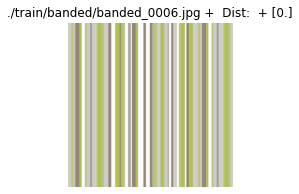

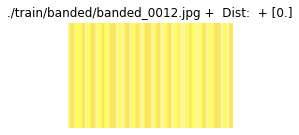

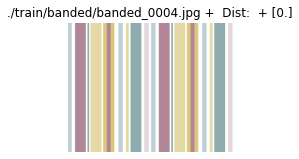

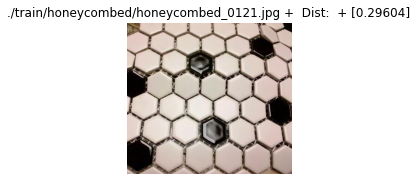

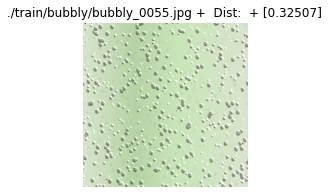

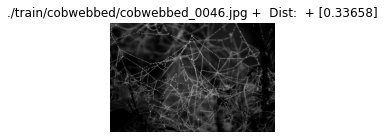

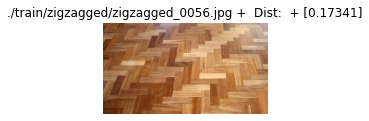

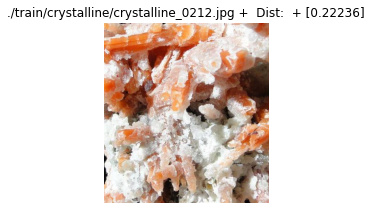

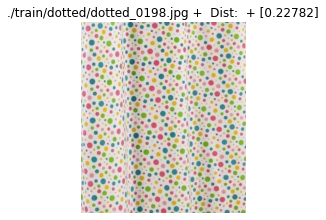

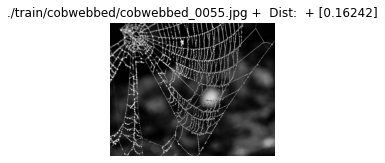

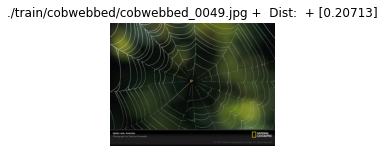

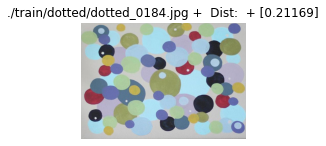

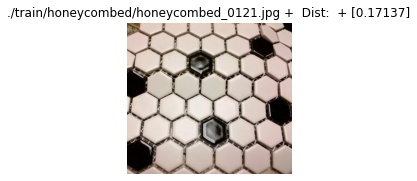

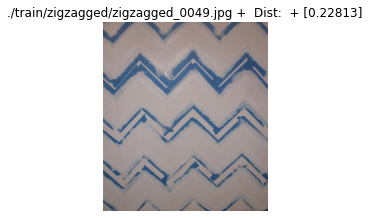

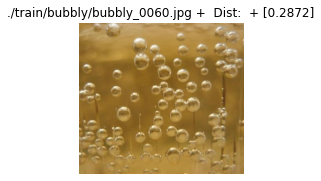

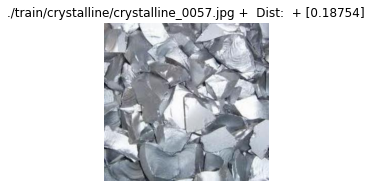

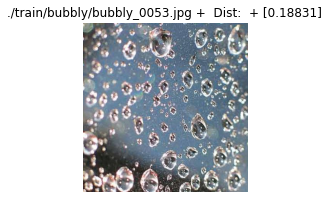

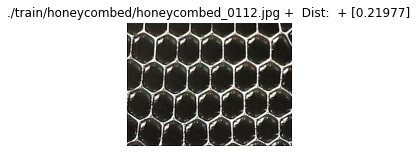

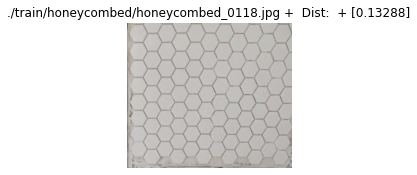

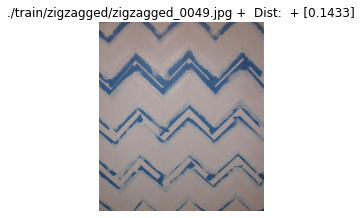

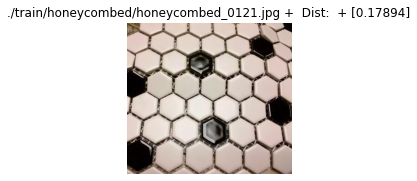

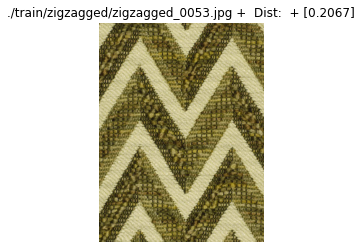

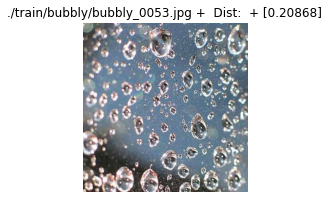

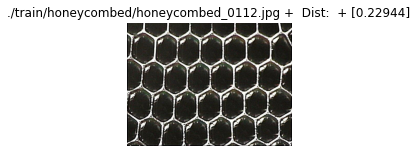

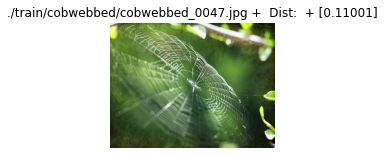

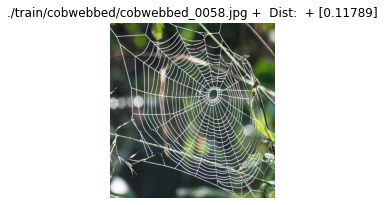

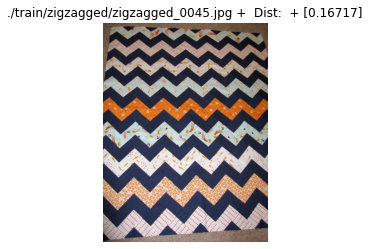

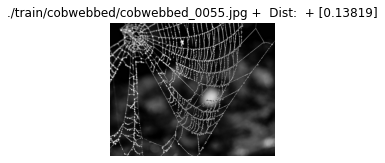

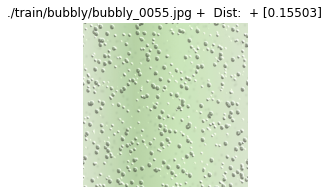

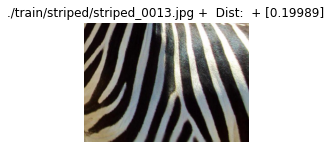

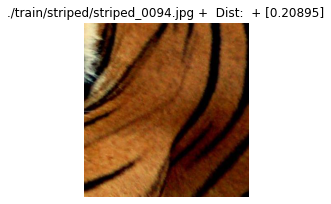

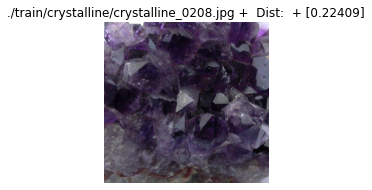

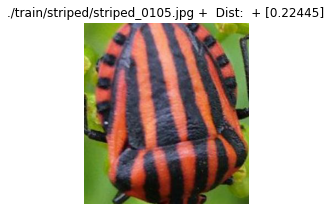

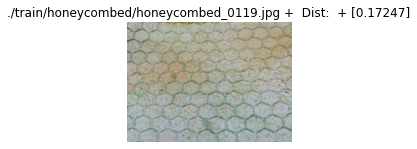

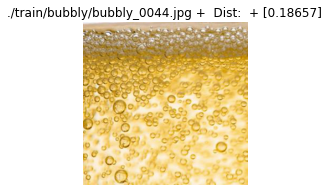

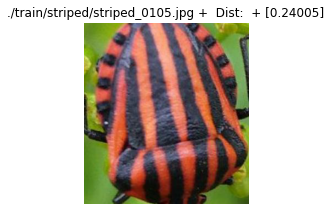

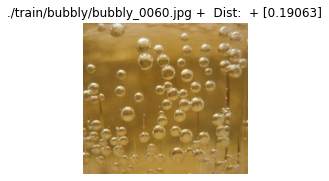

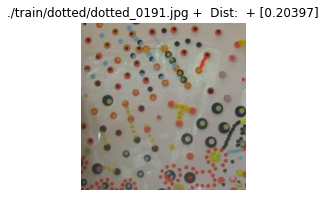

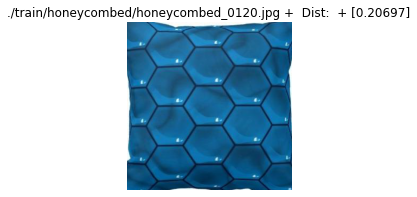

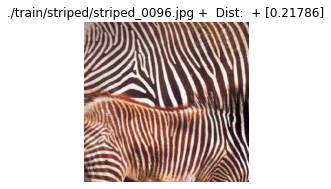

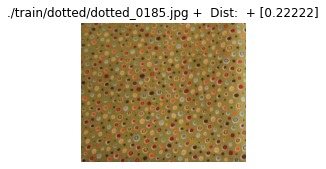

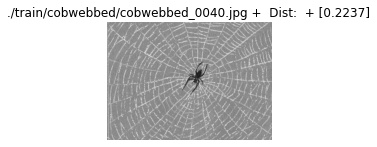

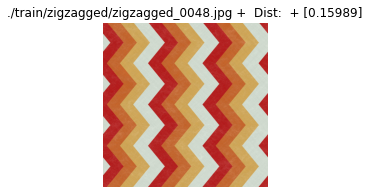

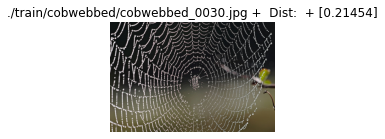

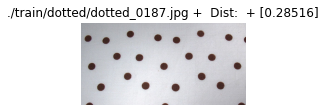

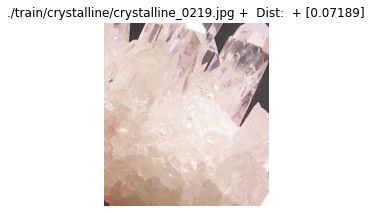

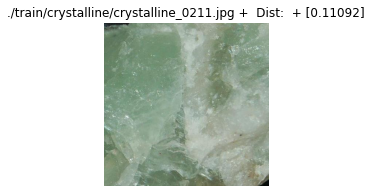

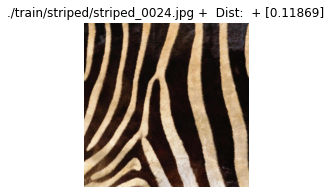

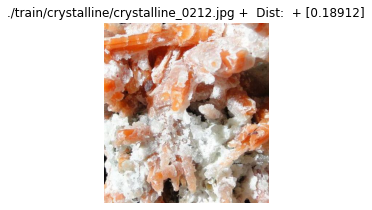

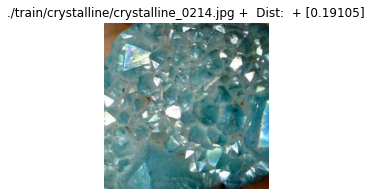

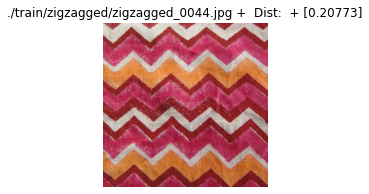

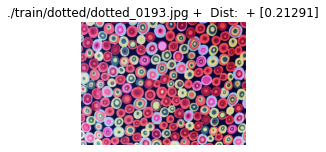

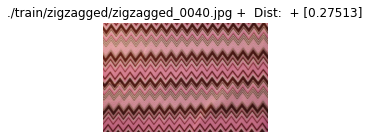

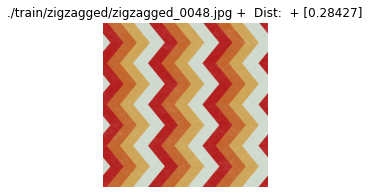

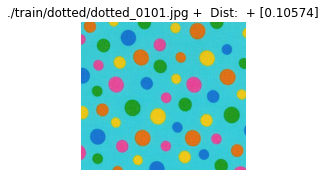

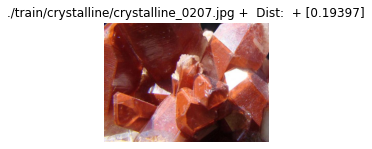

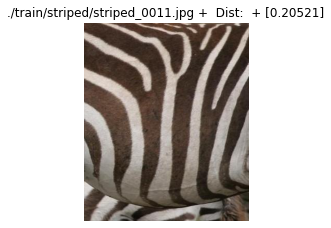

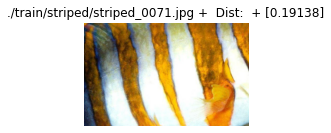

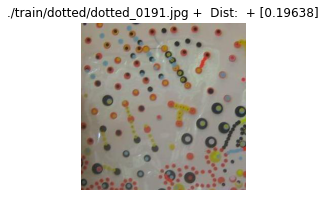

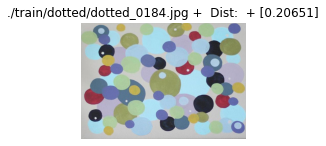

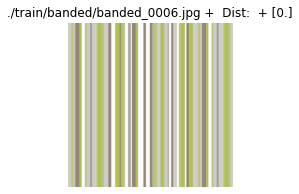

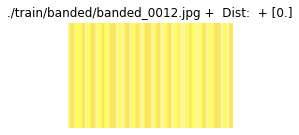

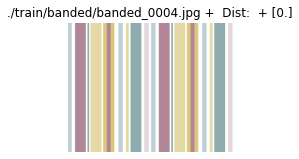

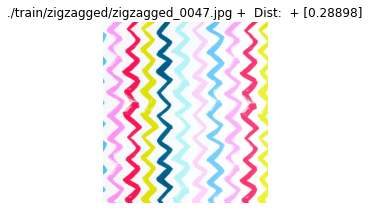

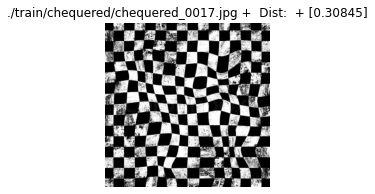

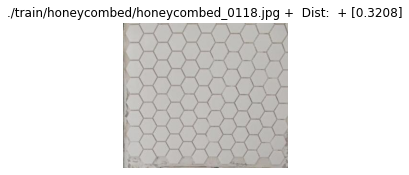

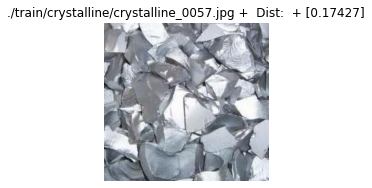

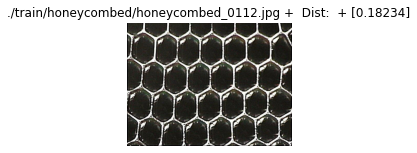

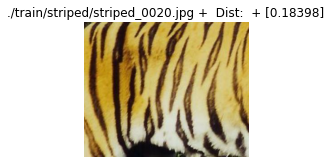

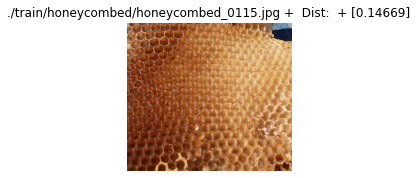

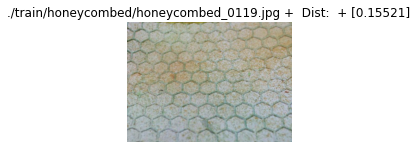

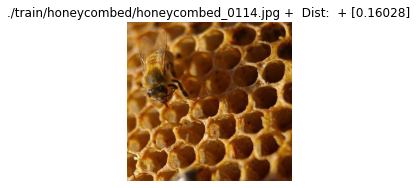

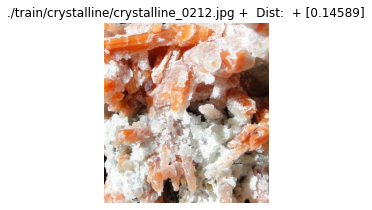

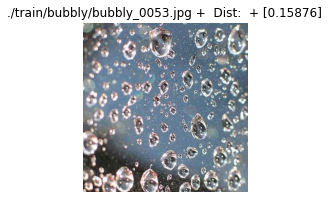

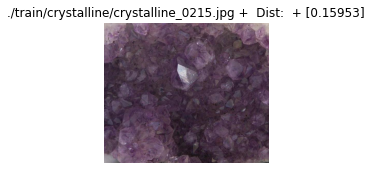

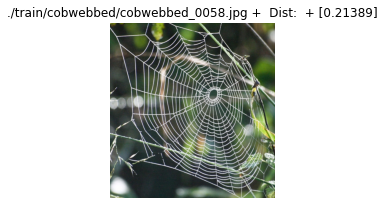

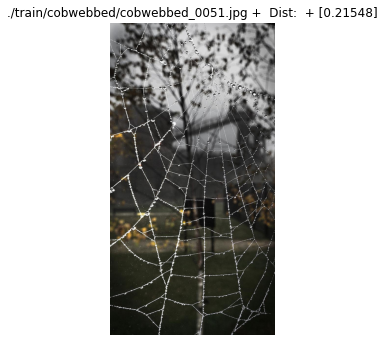

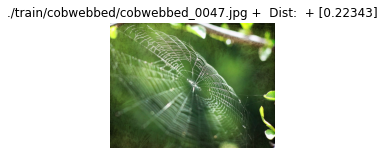

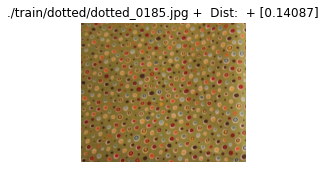

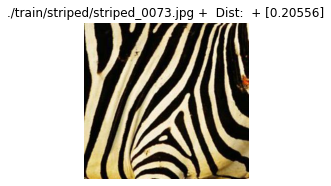

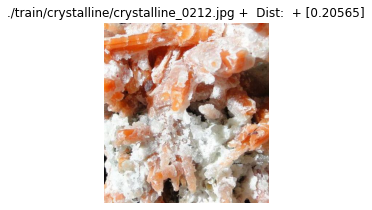

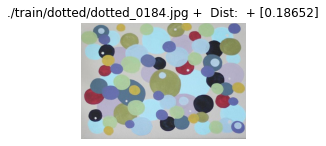

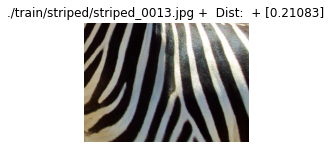

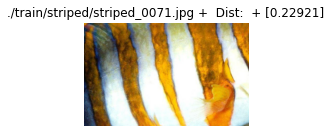

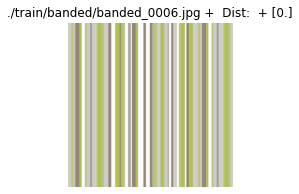

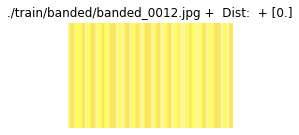

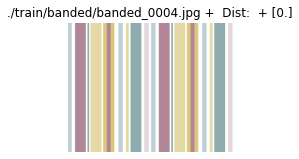

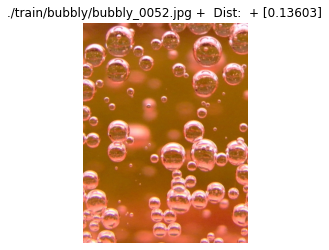

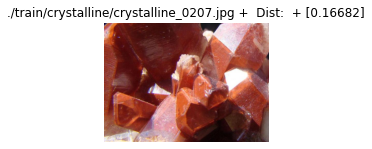

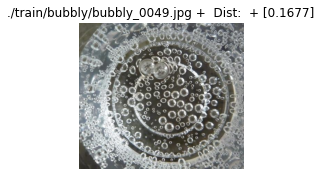

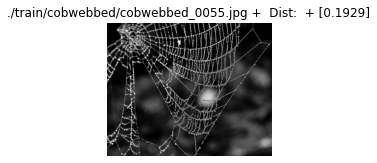

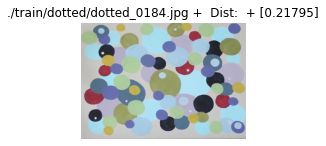

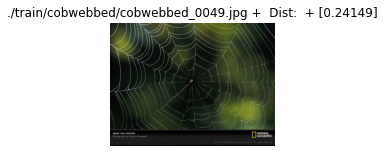

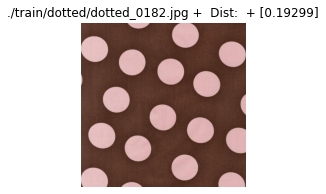

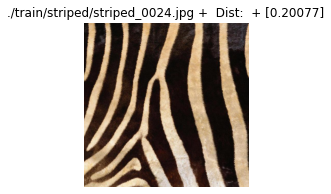

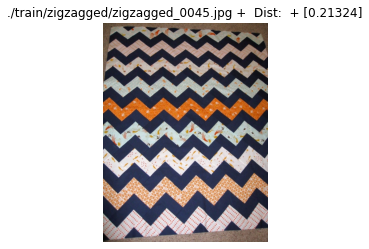

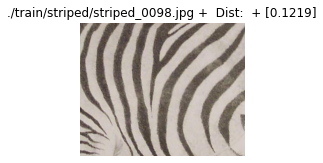

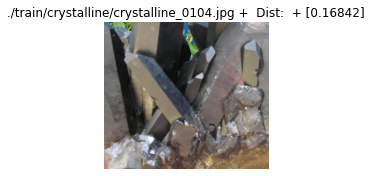

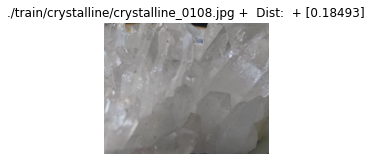

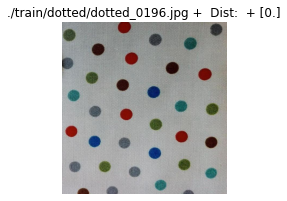

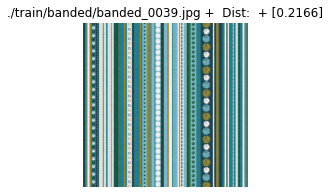

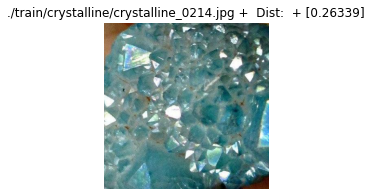

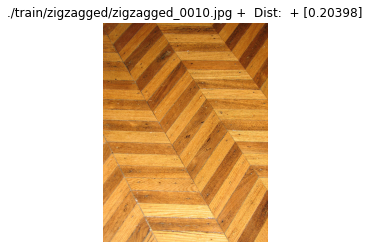

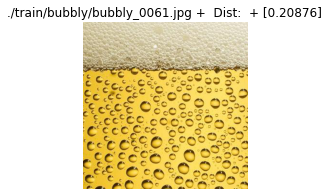

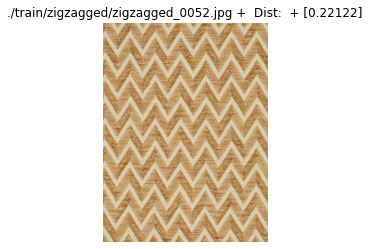

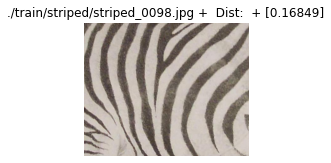

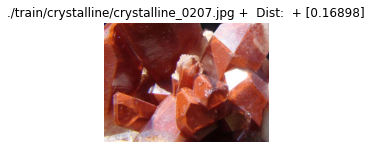

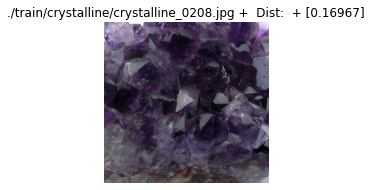

In [14]:
#train("train_data.txt")
test("train_data.txt", "test")
test("train_data.txt", "testForDocument")
#test, testForDocument and train directories should be at same directory with program file.